## Import Packages & Connect G drive

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LayerNormalization
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

import matplotlib.pyplot as plt

import sys

from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm


!pip install mat73
import mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
indices = np.random.choice(range(10), size=10)
print(indices)

[1 7 7 2 3 2 5 2 8 2]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

topic = 'Ming/'
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + topic
import os
os.chdir(work_dir)
!pwd
fig_path = work_dir + 'head_to_latent_fig/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Ming


## Load Data
from .mat file

In [4]:
################### transient heads ####################
field_type = 'Exponential'
pumping_type = 'transient'
data = mat73.loadmat('./Data/0719/'+field_type+'_'+pumping_type+'_monitored_0719_256.mat')
# data = mat73.loadmat('./Data/0714/'+field_type+'_'+pumping_type+'_monitored_0714.mat')


In [5]:
print(data.keys())
pump_well_id = data['pump_well_id'].astype(int)-1
print(pump_well_id)

y_save = data['y_save_monitored']

print(y_save.shape)

Z = data['Z'].T
print(Z.shape)
# fields = data['fields'].T
# fields = np.reshape(fields,(fields.shape[0],128,128))
# fields = np.transpose(fields, (0,2,1)).reshape((fields.shape[0],-1))
# print(fields.shape)

alpha = data['rv'].T
print(alpha.shape)
Y_raw = y_save
Y = np.zeros(y_save.shape)
Y = np.delete(Y,0,axis=1)
print(Y.shape)

for ii in range(Y.shape[-1]):
  # print(pump_well_id[ii])
  # print(np.argmin(Y_raw[3,:,8,ii]))

  Y[:,:,:,ii] = np.delete(Y_raw[:,:,:,ii],pump_well_id[ii],axis=1)
  # print(np.sort(Y_raw[3,:,8,ii])[:2])
  # print(np.min(Y[3,:,8,ii]))

select_time_steps = np.arange(2,11,2)
print(select_time_steps)
Y = Y[:,:,select_time_steps,:]
NR = Y.shape[0]
Y = Y.reshape([NR,-1])
print(Y.shape)


dict_keys(['Z', 'pump_well_id', 'rv', 'y_save_monitored'])
[ 0  4 12 20 24]
(5000, 25, 11, 5)
(50, 65536)
(5000, 50)
(5000, 24, 11, 5)
[ 2  4  6  8 10]
(5000, 600)


In [6]:
# ########################################################
Y_noised = np.zeros_like(Y)
# Y_noised = Y
for i in range(Y.shape[0]):
  Y_noised[i]  = Y[i] + np.random.normal(0,np.abs(Y[i]*0.05),[1,Y[i].shape[0]])


alpha_mean = np.mean(alpha,axis=1)
alpha_std = np.std(alpha,axis=1)
alpha_normalized = np.divide(alpha - alpha_mean[:,None],  alpha_std[:,None])

# alpha_normalized = alpha
print(np.mean(alpha_normalized,axis=1).mean())
print(np.std(alpha_normalized,axis=1).mean())


train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha_normalized[:train_test_cut], alpha_normalized[train_test_cut:]
Y_train, Y_test = Y_noised[:train_test_cut], Y_noised[train_test_cut:]

print(X_train.shape, Y_train.shape)

print(Y_noised[0,1:10])
print(Y[0,1:10])


5.818310243321802e-19
1.0
(4500, 50) (4500, 600)
[-0.0327397  -0.10785976 -0.13434091 -0.03549495 -1.51380252 -0.05895467
 -0.16446903 -0.2184334  -0.07044548]
[-0.03256693 -0.10545201 -0.13197962 -0.03784118 -1.36238903 -0.0592297
 -0.17837321 -0.22595043 -0.07339149]


## PCA Decode

should reshape(order='F') to match Matlab matrix

Text(0.5, 1.0, 'Inverse with PCA')

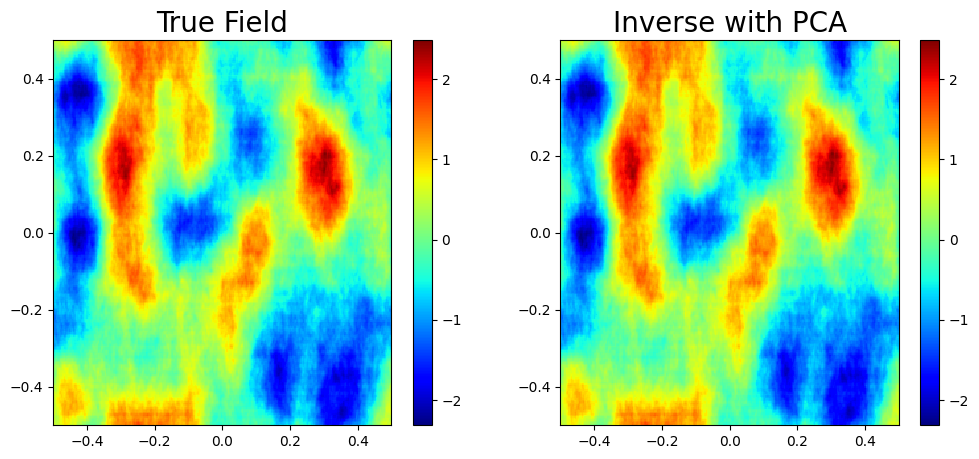

In [7]:
ss_train = np.matmul(alpha,Z)
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = int(np.sqrt(Z.shape[1])), int(np.sqrt(Z.shape[1]))
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)
# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])

Xm, Ym = np.meshgrid(x,y)

fid = 9
fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,np.reshape(np.matmul(alpha[fid],Z), (nx,ny),'F'), cmap='jet')
fig.colorbar(im, ax=ax)
ax.set_title('True Field',fontsize=20)


ax = axs[1]
im = ax.pcolormesh(Xm,Ym,ss_train[fid].reshape((nx,ny),order='F'), cmap='jet')
fig.colorbar(im, ax=ax)
ax.set_title('Inverse with PCA',fontsize=20)

In [8]:
#################  well network cell id ##################
well_id = np.arange(25)

# pump well matrix-wise index (index on x and y axis)
xloc = np.arange(int(nx/4),int(nx*3/4+1),int(nx/8))
yloc = np.arange(int(ny/4),int(ny*3/4+1),int(ny/8))

xloc = np.repeat(xloc,5)
yloc = np.tile(yloc,5)

# pump well index
pump_cell_idx = xloc + yloc*ny
print(pump_cell_idx)

[16448 24640 32832 41024 49216 16480 24672 32864 41056 49248 16512 24704
 32896 41088 49280 16544 24736 32928 41120 49312 16576 24768 32960 41152
 49344]


## Define NN Model

Input: Heads (normalized)

Output: Latent variables (alpha)


In [9]:
# hidden_act = None
# hidden_dim = 3000
# hidden_normal = LayerNormalization(axis=1) # BatchNormalization()
# input = Input(shape = (Y_train.shape[-1],))
# g = BatchNormalization()(input)

# g = Dense(hidden_dim)(g)
# g = LayerNormalization(axis=1)(g)
# g = LeakyReLU(alpha=0.2)(g)

# g = Dense(hidden_dim)(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)

# g = Dense(hidden_dim)(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)

# g = Dense(hidden_dim)(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)

# g = Dense(hidden_dim)(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)

# g_out = Dense(50)(g)
# g_out = LayerNormalization(axis=1)(g_out)

# G = Model(input, g_out, name = field_type+'_'+pumping_type)
# G.summary()


eigen_values = np.loadtxt('./Data/'+field_type+'_eigen.csv',dtype=np.float64)
alpha_loss_weight = np.ones((50,))
# alpha_loss_weight= eigen_values[0:50]

# alpha_loss_weight /= np.linalg.norm(alpha_loss_weight)


def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss

# step = tf.Variable(0, trainable=False)
# boundaries = [10000, 20000]
# values = [1e-4, 1e-5, 1e-6]
# learning_rate_fn = PiecewiseConstantDecay(
#     boundaries, values)

# # Later, whenever we perform an optimization step, we pass in the step.
# learning_rate = learning_rate_fn(step)

# # learning_rate = 0.0005
# print(learning_rate)
# G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

## Train Model

In [10]:
# batch_size = 1000

# epochs = 50000
# print_interval = 1000
# for epoch in range(epochs):
#   idx = np.random.randint(0, Y_train.shape[0], batch_size)
#   to_train = Y_train[idx]
#   expect_output = X_train[idx]

#   loss = G.train_on_batch(to_train, expect_output)
#   if epoch % print_interval == 0:
#       print("[epoch %d], [the loss is %f]" % (epoch, loss))
#   if loss < 1e-5:
#     break

## Load saved model

In [50]:
model_name = './head_to_latent_model/'+field_type+'_'+pumping_type +'_5000_256_normalied_normlayer'
# G = load_model(model_name)

G = load_model(model_name, custom_objects={ 'loss': weighted_mse(alpha_loss_weight) })
G.summary()

Model: "Exponential_transient"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization_10 (Bat  (None, 600)              2400      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 3000)              1803000   
                                                                 
 layer_normalization_5 (Laye  (None, 3000)             6000      
 rNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 3000)              0         
                                                                 
 dense_13 (Dense)            (None, 3000)    

## Inverse on test data set

In [51]:
predictions = G.predict(Y_test)

print(predictions.shape)

pred_imgs = np.matmul(predictions,Z)
# X_test = np.normalize(X_test)
true_imgs = np.matmul(X_test,Z)


16/16 [==============================] - 0s 3ms/step
(500, 50)


In [52]:
print(Z.shape)
print(pred_imgs.shape)


(50, 65536)
(500, 65536)


In [14]:
# np.savetxt('./Data/0719/'+field_type+'_'+pumping_type+'_preds_0719_256.csv', predictions)

# np.savetxt('./Data/0719/'+field_type+'_'+pumping_type+'_Z_0719_256.csv', Z)

head_data = mat73.loadmat('./Data/0719/'+field_type+'_'+pumping_type+'_pred_heads_0719_256.mat')

pred_heads = head_data['pred_y']
ref_heads = head_data['ref_y']

In [53]:
acc_list = np.zeros((1,Y_test.shape[0]))
thres = 0.15

err_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  logK_true = true_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[0,check_id] = acc

  ##### relative residual of head #####
  head_pred = pred_heads[check_id,...].flatten()
  head_true = Y_test[check_id].flatten()
  err_list[0,check_id] = np.linalg.norm(head_pred-head_true,2)/np.linalg.norm(head_true,2)

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))
# top5_est_list = np.argsort(acc_list)[0,-5:]
# print(top5_est_list)

print("Min err: ", np.min(err_list))
print("Max err: ", np.max(err_list))
print("Arg Max err: ", np.argmax(err_list))

print("mean err: ", np.mean(err_list))
print("std err: ", np.std(err_list))

Min Acc:  0.670501708984375
Max Acc:  0.97607421875
Arg Max Acc:  482
Over 90%:  105
mean Acc:  0.8468193969726563
std Acc:  0.06121012183003786
Min err:  0.06164963075089765
Max err:  1.0
Arg Max err:  499
mean err:  0.1310886740526503
std err:  0.05580111162519753


In [16]:
top5_est_list = np.argsort(acc_list)[0,-10:]
print(top5_est_list)

bot5_est_list = np.argsort(acc_list)[0,0:10]
print(bot5_est_list)

top_alpha_mean = np.mean(X_test[top5_est_list],axis=1)
top_alpha_std = np.std(X_test[top5_est_list],axis=1)
print(top_alpha_mean.mean())
print(top_alpha_std.mean())

bot_alpha_mean = np.mean(X_test[bot5_est_list],axis=1)
bot_alpha_std = np.std(X_test[bot5_est_list],axis=1)
print(bot_alpha_mean.mean())
print(bot_alpha_std.mean())

[341  39 226 115 415 420  74  38 482  69]
[419 400  48  51 272 394 147   4  43 429]
2.55351295663786e-18
0.9999999999999998
-7.036038418561931e-18
1.0


482
0.8109184019788237
0.9456539311696627
-0.9078232699122597 -0.07566304027527451
-0.8298685246297468 -0.06149652965195353
0.9751129150390625


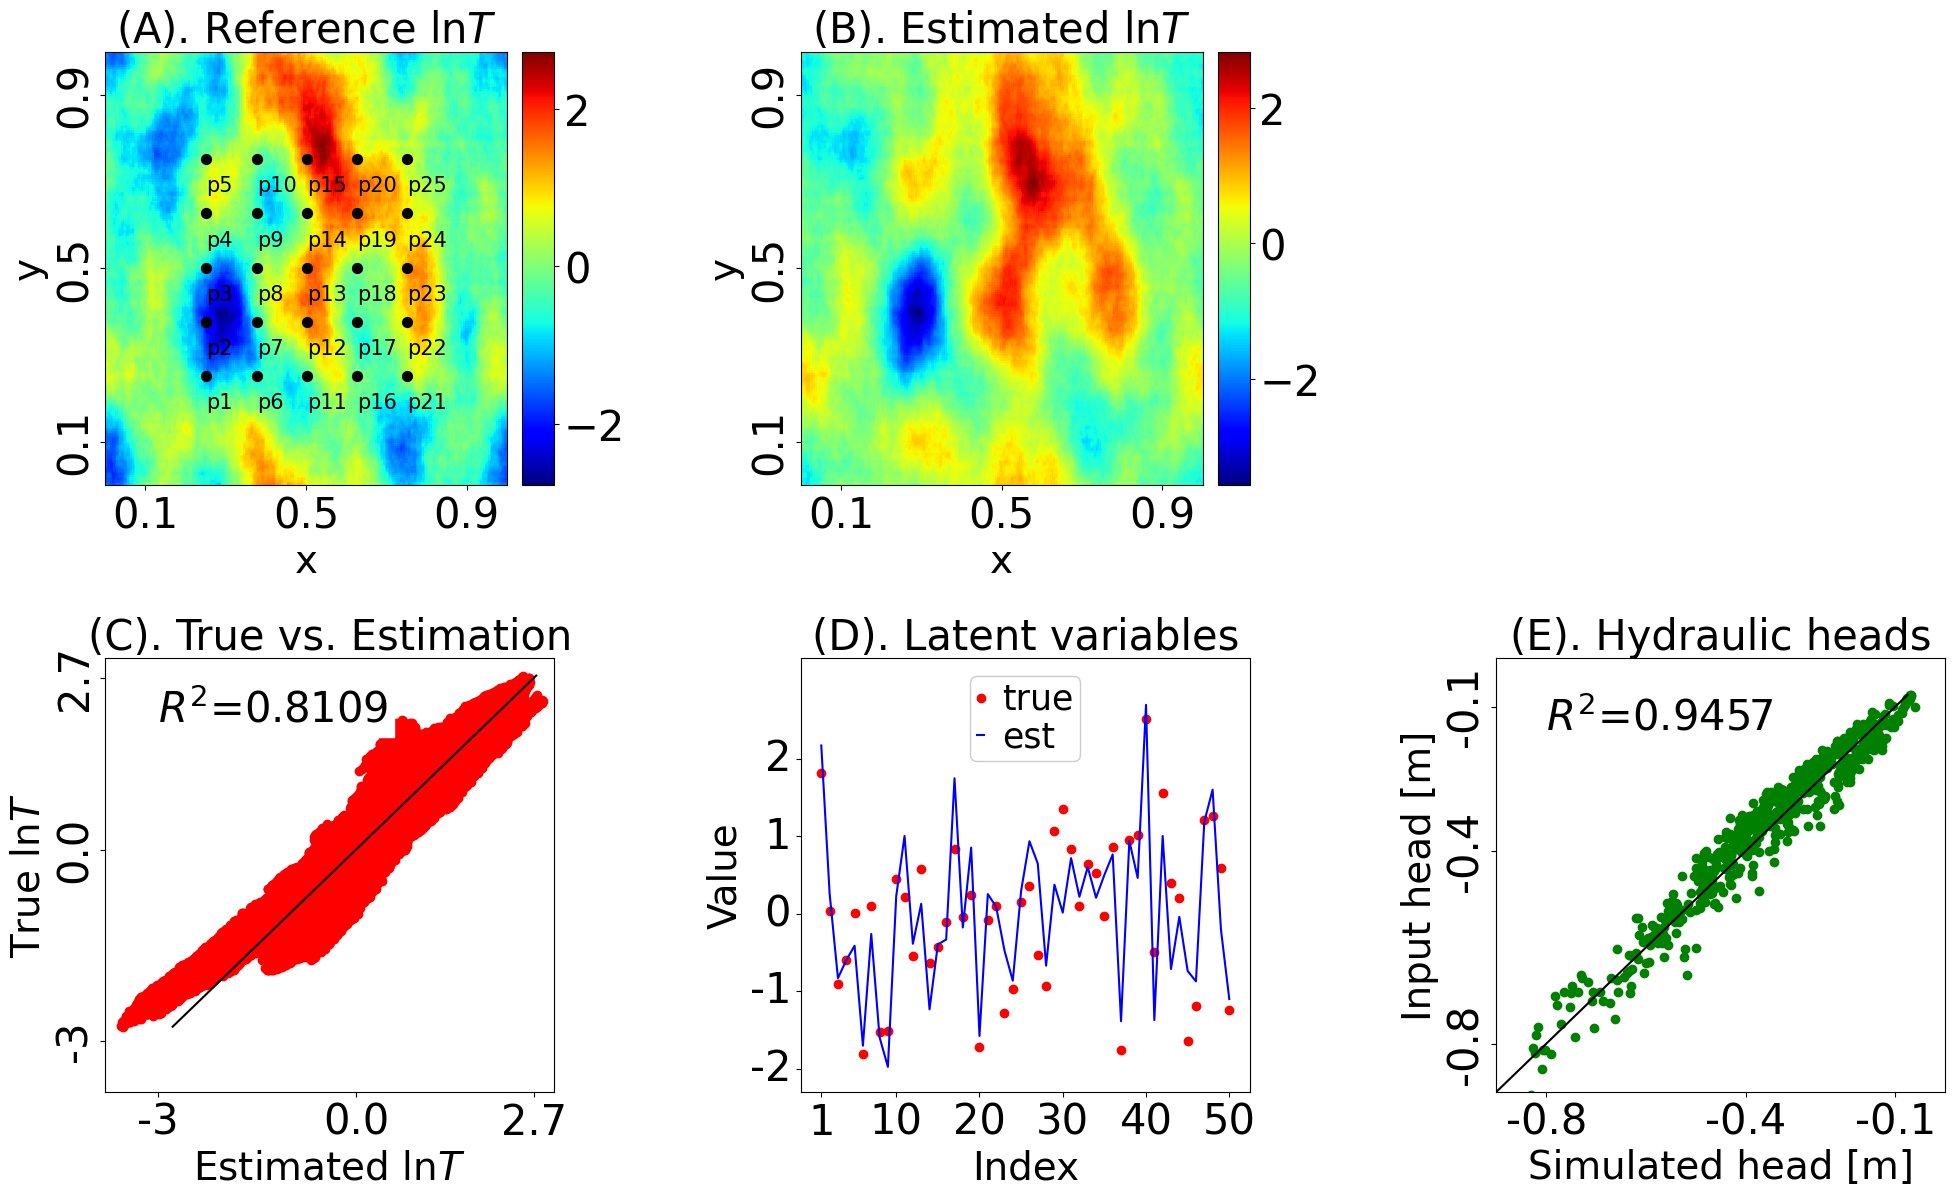

In [54]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
print(fid)
fid=105
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30
logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(2,3,figsize=(23,13), gridspec_kw={'width_ratios': [1, 1, 1]})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.4)

axs = axs.flatten()
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

pump_id_list = np.arange(1,25)
# shift = 40
shift = -256*10
for i in range(25):
  texts = 'p'+str(i+1)
  ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, c='k', fontsize=15, ha='left', va='top')
ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")
# ax.scatter(X_star[pump_cell_idx[pump_id_list],0], X_star[pump_cell_idx[pump_id_list],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")



######################################
######################################
######################################
ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimated ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')



######################################
######################################
######################################
# fig,ax = plt.subplots(figsize=(5.6,5.6))
# #set font size
# axis_label_font_size = 28
# axis_tick_font_size = 30
# legend_fontszie = 25
# colorbar_font_size = 30
# title_size = 28

######### compute r2 score of the regression: logK = inv_logK #########
logK_true_plot = logK_true.flatten()
logK_pred_plot = logK_pred.flatten()
var_model = np.sum((logK_pred_plot - logK_true_plot)**2)
var_data = np.sum((logK_true_plot-np.mean(logK_true_plot))**2)
r2_inverse_logK = (var_data-var_model) / var_data
print(r2_inverse_logK)

######### plot logK scatter: true vs. estimation #########

ax = axs[3]
min_logK_true_plot, max_logK_true_plot = min(logK_true_plot), max(logK_true_plot)
min_logK_pred_plot, max_logK_pred_plot = min(logK_pred_plot), max(logK_pred_plot)

ax.scatter(logK_pred_plot,logK_true_plot, label='logK',color='r')
ax.plot([min_logK_true_plot, max_logK_true_plot], [min_logK_true_plot, max_logK_true_plot],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_logK_true_plot, 0.0, max_logK_true_plot]
# labels = [min_logK_true_plot, 0.0, max_logK_true_plot]

ticks = [-3, 0.0, 2.7]
labels = [-3, 0.0, 2.7]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Estimated ln$T$',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-3.8, 3])
######### x-axis name, ticks and labels #########
ax.set_ylabel('True ln$T$',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-3.8, 3])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-3.0, 2.0, '$R^2$=%.4f'%(r2_inverse_logK), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(C). True vs. Estimation', fontsize=title_size)




######################################
######################################
######################################
ax = axs[4]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')


xticks = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
xlabels = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='upper center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(D). Latent variables',fontsize=title_size)



######### compute r2 score of the regression: head = inv_head #########
head_true_plot = Y_noised[fid+4500,...].flatten()
head_pred_plot = pred_heads[fid,...].flatten()
var_model = np.sum((head_pred_plot - head_true_plot)**2)
var_data = np.sum((head_true_plot-np.mean(head_true_plot))**2)
r2_inverse_head = (var_data-var_model) / var_data
print(r2_inverse_head)


######### plot head scatter: true vs. estimation #########

ax = axs[5]
min_head_true_plot, max_head_true_plot = min(head_true_plot), max(head_true_plot)
min_head_pred_plot, max_head_pred_plot = min(head_pred_plot), max(head_pred_plot)
print(min_head_true_plot, max_head_true_plot)
print(min_head_pred_plot, max_head_pred_plot)
ax.scatter(head_pred_plot,head_true_plot, label='head',color='g')
ax.plot([min_head_true_plot, max_head_true_plot], [min_head_true_plot, max_head_true_plot],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_head_true_plot, 0.0, max_head_true_plot]
# labels = [min_head_true_plot, 0.0, max_head_true_plot]

ticks = [-0.8,-0.4,-0.1]
labels = [-0.8,-0.4,-0.1]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Simulated head [m]',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-0.9, 0])
######### x-axis name, ticks and labels #########
ax.set_ylabel('Input head [m]',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-0.9, 0])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-0.8, -0.15, '$R^2$=%.4f'%(r2_inverse_head), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(E). Hydraulic heads', fontsize=title_size)


axs[2].axis('off')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'5plots_best.png',bbox_inches="tight")


In [ ]:
# #set font size
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # check_id = np.argmax(acc_list)
# fid = np.argmax(acc_list)
# print(fid)
# #set font size
# axis_label_font_size = 28
# axis_tick_font_size = 30
# legend_fontszie = 25
# colorbar_font_size = 30
# title_size = 30
# logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
# logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

# maxlK, minlK = np.max(logK_true), np.min(logK_true)

# fig, axs = plt.subplots(1,4,figsize=(29,5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
# # set the spacing between subplots
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.55, 
#                     hspace=0.4)


# ax = axs[0]
# im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
# im.set_clim((minlK, maxlK))
# ax.set_title('(A). Reference',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# # create an axes on the right side of ax. The width of cax will be 5%
# # of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.15)
# cbar = fig.colorbar(im, cax=cax)

# # cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

# # pump_id_list = np.arange(1,25)
# # # shift = 40
# # shift = -40-256*10
# # for i in range(25):
# #   texts = 'p'+str(i+1)
# #   ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, fontsize=15, ha='left', va='top')
# # ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")
# # # ax.scatter(X_star[pump_cell_idx[pump_id_list],0], X_star[pump_cell_idx[pump_id_list],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")



# ######################################
# ######################################
# ######################################
# ax = axs[1]
# im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# # im.set_clim((minlK, maxlK))

# ax.set_title('(B). Estimation',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# # cbar = fig.colorbar(im, ax=ax)
# # cbar.ax.tick_params(labelsize=colorbar_font_size)

# # create an axes on the right side of ax. The width of cax will be 5%
# # of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.15)
# cbar = fig.colorbar(im, cax=cax)

# # cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')



# ######################################
# ######################################
# ######################################
# # fig,ax = plt.subplots(figsize=(5.6,5.6))
# # #set font size
# # axis_label_font_size = 28
# # axis_tick_font_size = 30
# # legend_fontszie = 25
# # colorbar_font_size = 30
# # title_size = 28

# ######### compute r2 score of the regression: logK = inv_logK #########
# logK_true_plot = logK_true.flatten()
# logK_pred_plot = logK_pred.flatten()
# var_model = np.sum((logK_pred_plot - logK_true_plot)**2)
# var_data = np.sum((logK_true_plot-np.mean(logK_true_plot))**2)
# r2_inverse_logK = (var_data-var_model) / var_data
# print(r2_inverse_logK)

# ######### plot logK scatter: true vs. estimation #########

# ax = axs[2]
# min_logK_true_plot, max_logK_true_plot = min(logK_true_plot), max(logK_true_plot)
# min_logK_pred_plot, max_logK_pred_plot = min(logK_pred_plot), max(logK_pred_plot)

# ax.scatter(logK_pred_plot,logK_true_plot, label='logK',color='r')
# ax.plot([min_logK_true_plot, max_logK_true_plot], [min_logK_true_plot, max_logK_true_plot],color='k')
# # ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# # ticks = [min_logK_true_plot, 0.0, max_logK_true_plot]
# # labels = [min_logK_true_plot, 0.0, max_logK_true_plot]

# ticks = [-3, 0.0, 2.8]
# labels = [-3, 0.0, 2.8]

# ######### x-axis name, ticks and labels #########
# ax.set_xlabel('Estimate ln$T$',fontsize=axis_label_font_size)
# ax.set_xticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_xlim([-3.8, 3])
# ######### x-axis name, ticks and labels #########
# ax.set_ylabel('True ln$T$',fontsize=axis_label_font_size)
# ax.set_yticks(ticks)
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
# ax.set_ylim([-3.8, 3])

# # ######### figure title #########
# # ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

# ######### xfigure text #########
# ax.text(-3.0, 2.0, '$R^2$=%.4f'%(r2_inverse_logK), fontsize=30,
#         bbox={'edgecolor':'w','facecolor':'w'})

# ax.set_title('(C). True vs. estimates', fontsize=title_size)




# ######################################
# ######################################
# ######################################
# ax = axs[3]
# xplot = np.arange(1, predictions.shape[1]+1)
# ax.plot(xplot, X_test[fid,:],'or',label='true')
# ax.plot(xplot, predictions[fid,:],'b',label='est')


# xticks = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
# xlabels = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

# yticks = np.arange(-2, 3)
# ylabels = np.arange(-2, 3)
# ax.set_yticks(yticks)
# ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

# ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
#              np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

# ax.set_xlabel('Index',fontsize=axis_label_font_size)
# ax.set_ylabel('Value',fontsize=axis_label_font_size)

# ax.legend(loc='bottom center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
#           facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

# ax.set_title('(D). Latent variables',fontsize=title_size)




# # threshold 10%
# thres = 0.15
# K_len = maxlK - minlK 

# acc = abs(logK_true-logK_pred)/K_len

# print(sum(sum(acc<thres))/(nx*ny))

# fig.savefig(fig_path+field_type+'_'+pumping_type+'4plots__best.png',bbox_inches="tight")


## Best Estimates

0.9761810302734375


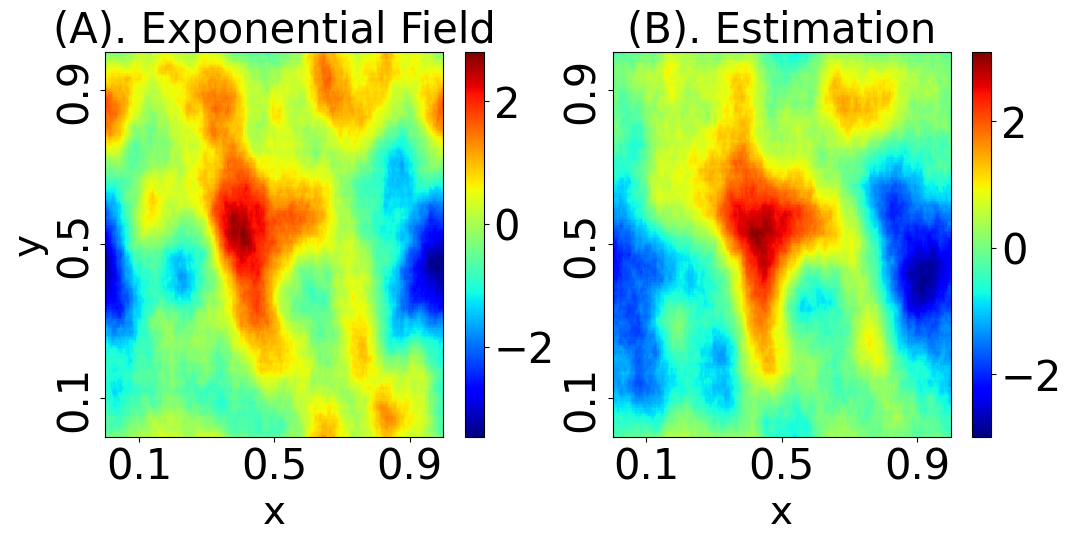

In [ ]:
# # check_id = np.argmax(acc_list)
# fid = top5_est_list[-1]

# #set font size
# axis_label_font_size = 28
# axis_tick_font_size = 30
# legend_fontszie = 25
# colorbar_font_size = 30
# title_size = 30

# logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
# logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

# maxlK, minlK = np.max(logK_true), np.min(logK_true)

# fig, axs = plt.subplots(1,2,figsize=(12,5))
# ax = axs[0]
# im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
# im.set_clim((minlK, maxlK))
# ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# ax = axs[1]
# im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# # im.set_clim((minlK, maxlK))

# ax.set_title('(B). Estimation',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# # ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# # threshold 10%
# thres = 0.15
# K_len = maxlK - minlK 

# acc = abs(logK_true-logK_pred)/K_len

# print(sum(sum(acc<thres))/(nx*ny))

# fig.savefig(fig_path+field_type+'_'+pumping_type+'_best.png',bbox_inches="tight")


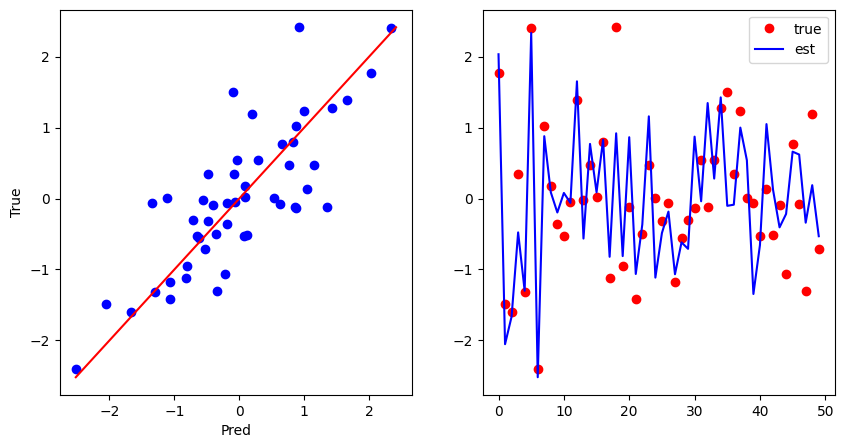

In [ ]:
# check_id = fid
# fig, axs = plt.subplots(1,2,figsize=(10,5))

# ax = axs[0]
# plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
# plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

# ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
# ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
# ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

# ax.set_xlabel('Pred')
# ax.set_ylabel('True')

# ax = axs[1]
# xplot = np.arange(predictions.shape[1])
# ax.plot(xplot, X_test[check_id,:],'or',label='true')
# ax.plot(xplot, predictions[check_id,:],'b',label='est')

# ax.legend()

# Wrost Estimate

0.614837646484375


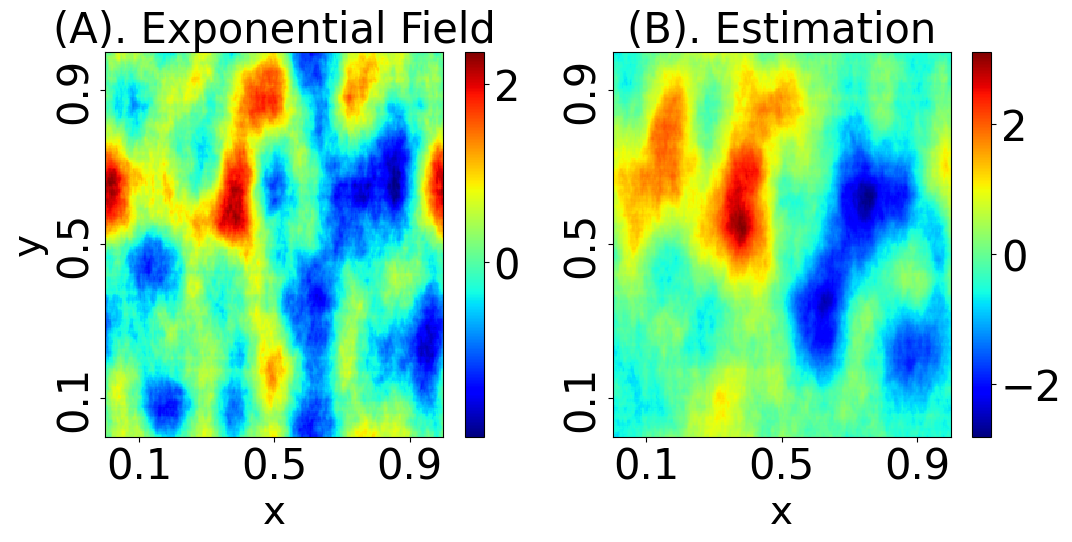

In [ ]:
# # check_id = np.argmax(acc_list)
# fid = np.argmin(acc_list)

# #set font size
# axis_label_font_size = 28
# axis_tick_font_size = 30
# legend_fontszie = 25
# colorbar_font_size = 30
# title_size = 30

# logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
# logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

# maxlK, minlK = np.max(logK_true), np.min(logK_true)

# fig, axs = plt.subplots(1,2,figsize=(12,5))
# ax = axs[0]
# im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
# im.set_clim((minlK, maxlK))
# ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# ax = axs[1]
# im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# # im.set_clim((minlK, maxlK))

# ax.set_title('(B). Estimation',fontsize=title_size)

# ax.set_xlabel('x',fontsize=axis_label_font_size)
# # ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# ticks = [-0.4, 0.0, 0.4]

# labels = [0.1, 0.5, 0.9]
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
# ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# # threshold 10%
# thres = 0.15
# K_len = maxlK - minlK 

# acc = abs(logK_true-logK_pred)/K_len

# print(sum(sum(acc<thres))/(nx*ny))

# fig.savefig(fig_path+field_type+'_'+pumping_type+'_wrost.png',bbox_inches="tight")


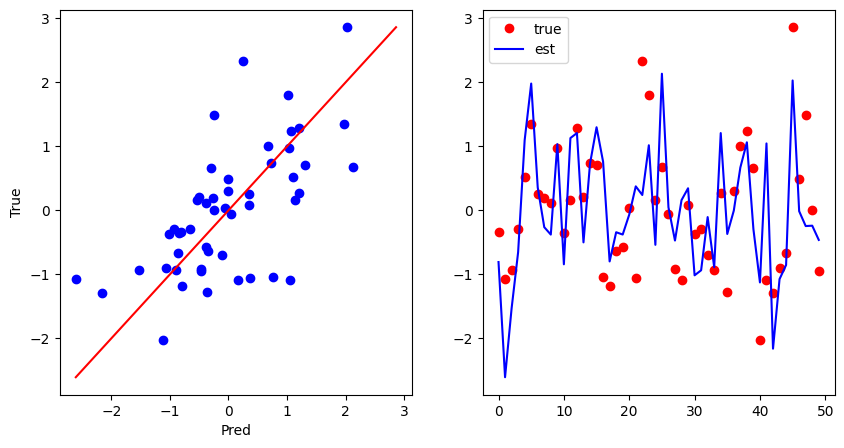

In [ ]:
# check_id = fid
# fig, axs = plt.subplots(1,2,figsize=(10,5))

# ax = axs[0]
# plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
# plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

# ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
# ax.plot(predictions[check_id,15:],X_test[check_id,15:],'ob')
# ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

# ax.set_xlabel('Pred')
# ax.set_ylabel('True')

# ax = axs[1]
# xplot = np.arange(predictions.shape[1])
# ax.plot(xplot, X_test[check_id,:],'or',label='true')
# ax.plot(xplot, predictions[check_id,:],'b',label='est')

# ax.legend()

# Uncertainty Quantification

In [ ]:
n_noises = 20

Noised_Y_test = Y_test[fid] + np.random.normal(0,np.abs(Y_test[fid]*0.05),[n_noises,Y_test[fid].shape[0]])

uq_predictions = G.predict(Noised_Y_test)
std_predictions = np.std(uq_predictions,axis =0)

print(std_predictions.shape)
uq_pred_imgs = np.matmul(uq_predictions,Z)
var_up_pred_imgs = np.var(uq_pred_imgs.reshape((n_noises,nx,ny), order='F'),axis=0)
acc_list = np.zeros((n_noises,))
thres = 0.15

for check_id in range(n_noises):

  uq_logK_pred = uq_pred_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-uq_logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))



1/1 [==============================] - 0s 53ms/step
(50,)
Min Acc:  0.8383941650390625
Max Acc:  0.886199951171875
Arg Max Acc:  7
Over 90%:  0
mean Acc:  0.8669761657714844
std Acc:  0.010973066458557812


214
0.6058191331157438
0.904407975525344
-0.7653561709590574 -0.04117457181959522
-0.7837851246155622 -0.028964860396502607
0.8463897705078125


[Text(0, -0.4, '0.1'), Text(0, 0.0, '0.5'), Text(0, 0.4, '0.9')]

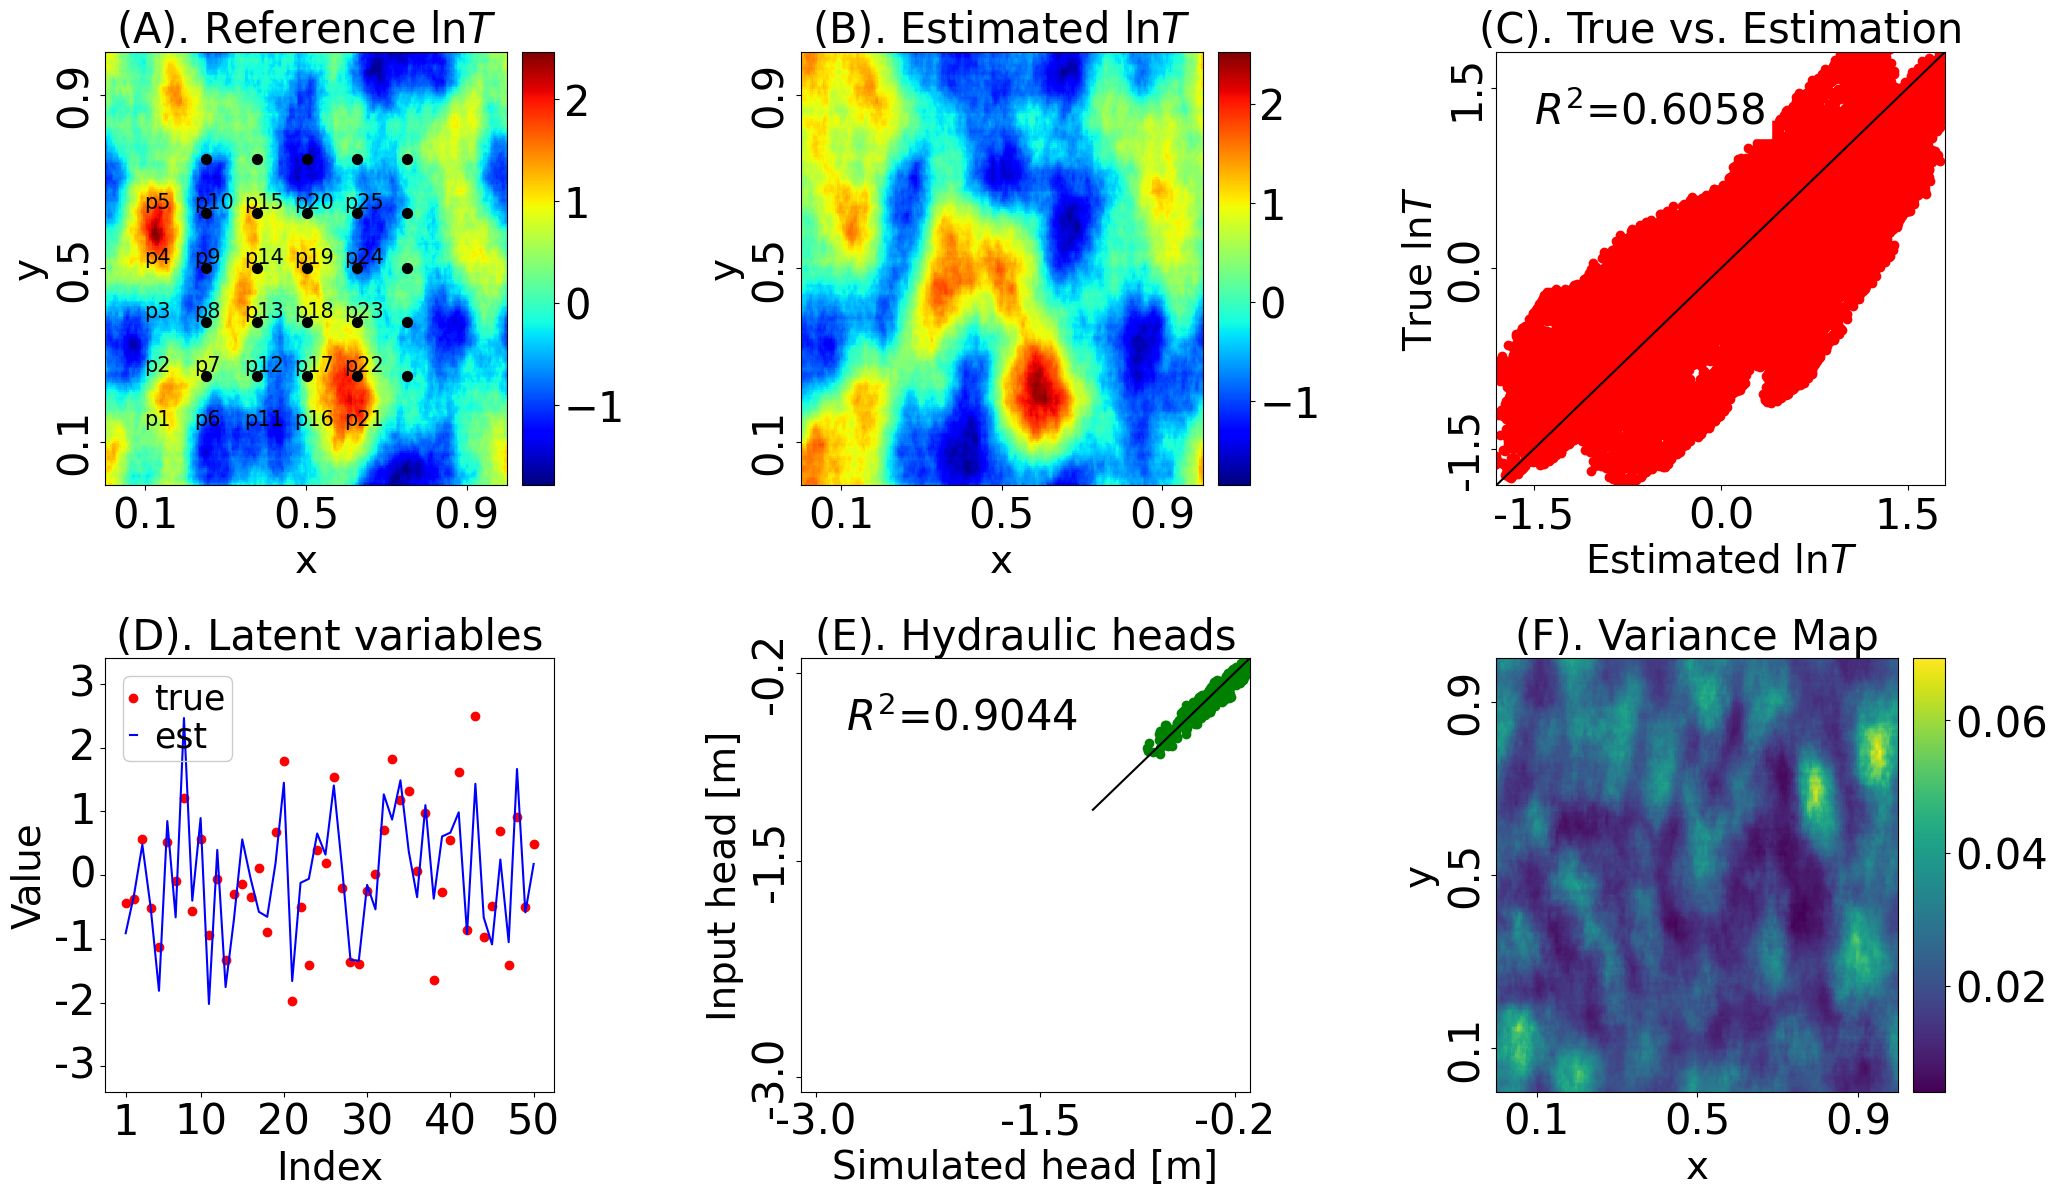

In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
fid=214
print(fid)
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30
logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(2,3,figsize=(23,13), gridspec_kw={'width_ratios': [1, 1, 1]})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.4)

axs = axs.flatten()
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

pump_id_list = np.arange(1,25)
# shift = 40
shift = -40-512*10
for i in range(25):
  texts = 'p'+str(i+1)
  ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, c='k', fontsize=15, ha='left', va='top')
ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")
# ax.scatter(X_star[pump_cell_idx[pump_id_list],0], X_star[pump_cell_idx[pump_id_list],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")



######################################
######################################
######################################
ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='jet')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimated ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')



######### compute r2 score of the regression: logK = inv_logK #########
logK_true_plot = logK_true.flatten()
logK_pred_plot = logK_pred.flatten()
var_model = np.sum((logK_pred_plot - logK_true_plot)**2)
var_data = np.sum((logK_true_plot-np.mean(logK_true_plot))**2)
r2_inverse_logK = (var_data-var_model) / var_data
print(r2_inverse_logK)

######### plot logK scatter: true vs. estimation #########

ax = axs[2]
min_logK_true_plot, max_logK_true_plot = min(logK_true_plot), max(logK_true_plot)
min_logK_pred_plot, max_logK_pred_plot = min(logK_pred_plot), max(logK_pred_plot)

ax.scatter(logK_pred_plot,logK_true_plot, label='logK',color='r')
scaler = 1.5
ax.plot([min_logK_true_plot*scaler, max_logK_true_plot*scaler], [min_logK_true_plot*scaler, max_logK_true_plot*scaler],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_logK_true_plot, 0.0, max_logK_true_plot]
# labels = [min_logK_true_plot, 0.0, max_logK_true_plot]

ticks = [-1.5, 0.0, 1.5]
labels = [-1.5, 0.0, 1.5]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Estimated ln$T$',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-1.8, 1.8])
######### x-axis name, ticks and labels #########
ax.set_ylabel('True ln$T$',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-1.8, 1.8])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-1.5, 1.2, '$R^2$=%.4f'%(r2_inverse_logK), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(C). True vs. Estimation', fontsize=title_size)




######################################
######################################
######################################
ax = axs[3]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')
# ax.plot(xplot, predictions[fid,:]+2*std_predictions,'b.--',label= f'est$\pm$2std' )
# ax.plot(xplot, predictions[fid,:]-2*std_predictions,'b.--',label=None)

xticks = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
xlabels = [1, 10, 20, 30, 40, 50] #np.arange(1, predictions.shape[1]+1,9)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-4, 5)
ylabels = np.arange(-4, 5)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.4,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.4])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='upper left',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(D). Latent variables',fontsize=title_size)



######### compute r2 score of the regression: head = inv_head #########
head_true_plot = Y_test[fid,...].flatten()
head_pred_plot = pred_heads[fid,...].flatten()
var_model = np.sum((head_pred_plot - head_true_plot)**2)
var_data = np.sum((head_true_plot-np.mean(head_true_plot))**2)
r2_inverse_head = (var_data-var_model) / var_data
print(r2_inverse_head)


######### plot head scatter: true vs. estimation #########

ax = axs[4]
min_head_true_plot, max_head_true_plot = min(head_true_plot), max(head_true_plot)
min_head_pred_plot, max_head_pred_plot = min(head_pred_plot), max(head_pred_plot)
print(min_head_true_plot, max_head_true_plot)
print(min_head_pred_plot, max_head_pred_plot)
ax.scatter(head_pred_plot,head_true_plot, label='head',color='g')
ax.plot([min_head_true_plot*scaler, max_head_true_plot*0], [min_head_true_plot*scaler, max_head_true_plot*0],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_head_true_plot, 0.0, max_head_true_plot]
# labels = [min_head_true_plot, 0.0, max_head_true_plot]

ticks = [-3.0,-1.5,-0.2]
labels = [-3.0,-1.5,-0.2]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Simulated head [m]',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-3.1,-0.1])
######### x-axis name, ticks and labels #########
ax.set_ylabel('Input head [m]',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-3.1,-0.1])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-2.8,-0.6, '$R^2$=%.4f'%(r2_inverse_head), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(E). Hydraulic heads', fontsize=title_size)


# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

######################################
######################################
######################################
ax = axs[5]
im = ax.pcolormesh(Xm,Ym,var_up_pred_imgs)
# im.set_clim((minlK, maxlK))

ax.set_title('(F). Variance Map',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.15)
cbar = fig.colorbar(im, cax=cax)

# cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# fig.savefig(fig_path+field_type+'_'+pumping_type+'6plots_best.png',bbox_inches="tight")


[ 9  3 14  6 12 18 11 17  8  1]


ValueError: ignored

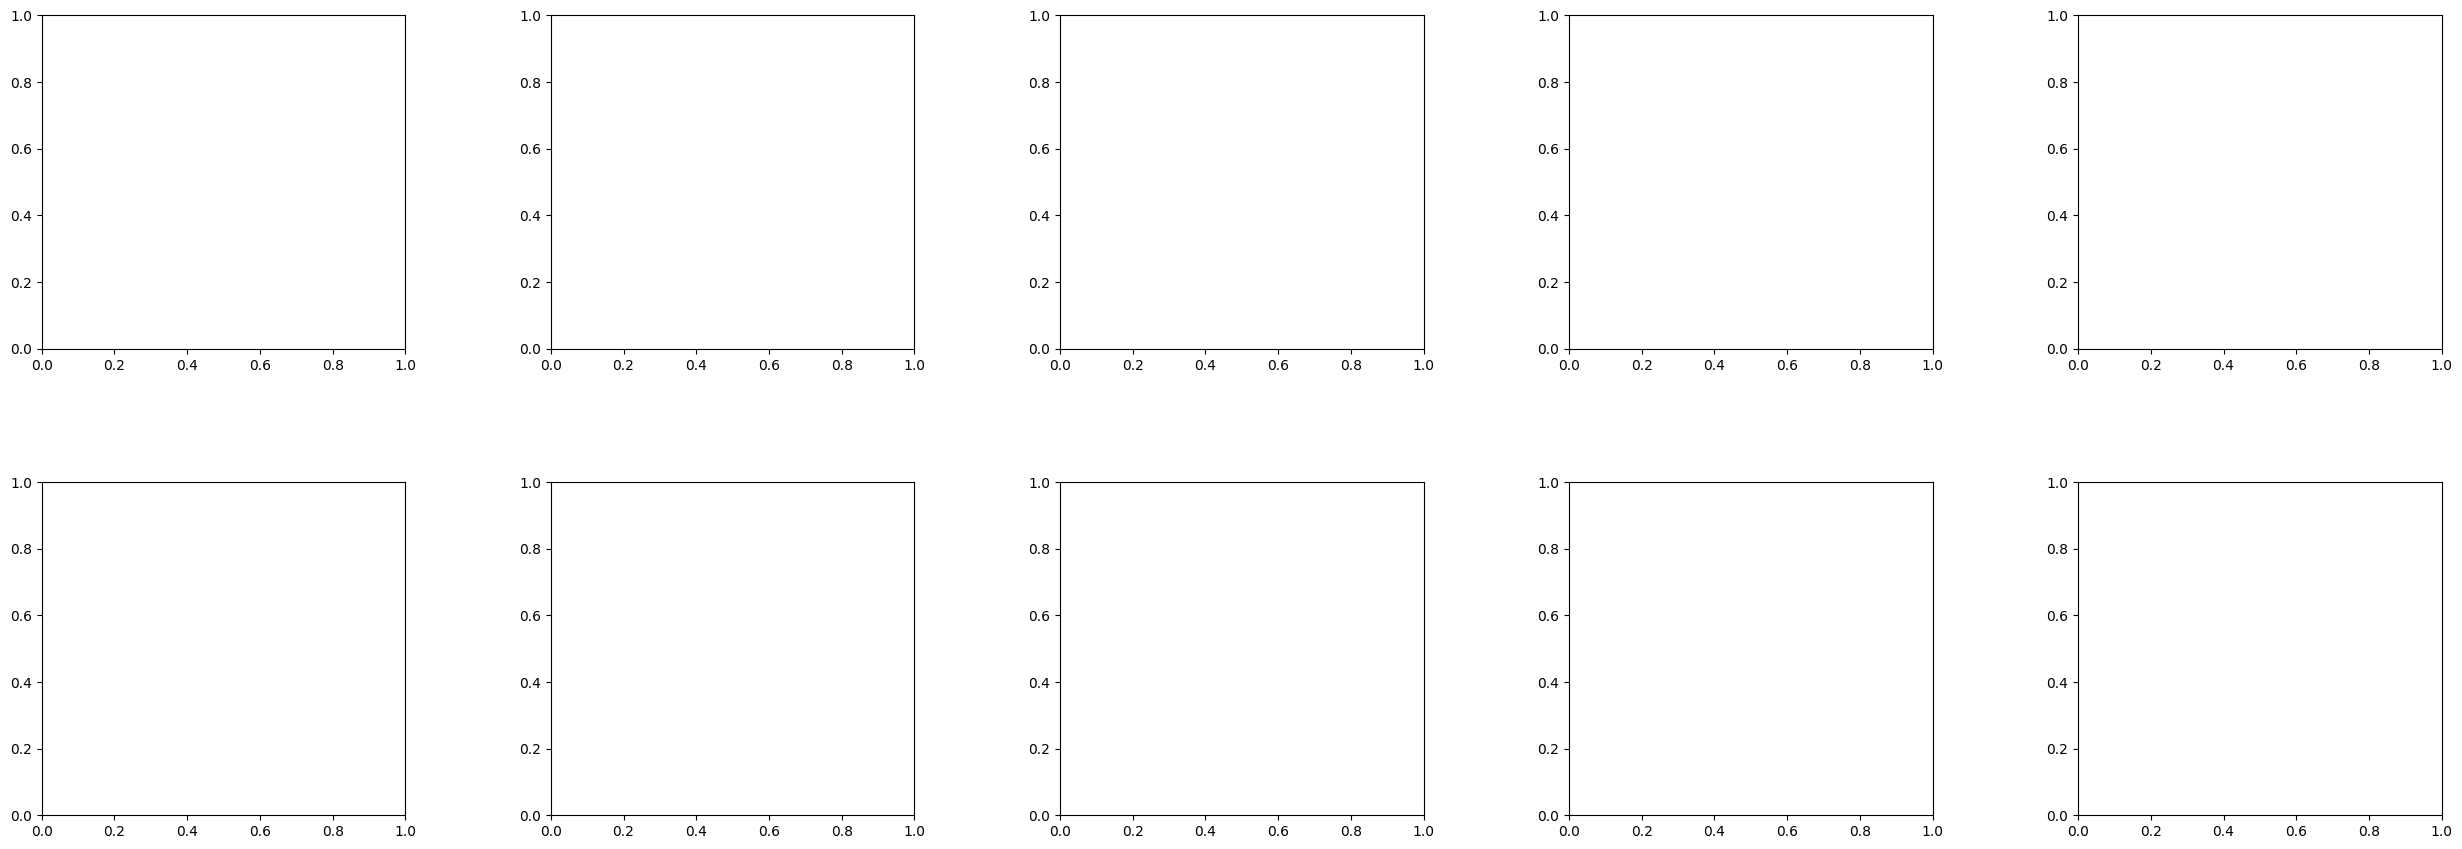

In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

axis_label_font_size = 20
axis_tick_font_size = 20
legend_fontszie = 20
colorbar_font_size = 20
title_size = 20

plot_id_list = np.argsort(acc_list)[-10:]

print(plot_id_list)
fig, axs = plt.subplots(2, 5, figsize=(30,10)) 

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

axs = axs.flatten()
logK_true = true_imgs.reshape((nx,ny), order='F')

for i in range(axs.shape[0]):
  ax = axs[i]
  logK_pred = pred_imgs[plot_id_list[i],:].reshape((nx,ny), order='F')

  if i == 0:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
    ax.set_title('True '+field_type+' Field',fontsize=title_size)

  else:
    im = ax.pcolormesh(Xm,Ym,logK_true, cmap='jet')
    acc = acc_list[plot_id_list[i]]*100
    ax_name = "Acc = %.2f %%" % acc
    ax.set_title(ax_name, fontsize=title_size)

  im.set_clim((minlK, maxlK))

  ax.set_xlabel('x',fontsize=axis_label_font_size)
  ax.set_ylabel('y',fontsize=axis_label_font_size)
    
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="10%", pad=0.15)
  cbar = fig.colorbar(im, cax=cax)

  # cbar = fig.colorbar(im, ax=ax, fraction=0.0000006, shrink=1.0)
  cbar.ax.tick_params(labelsize=colorbar_font_size)


  ticks = [-0.4, 0.0, 0.4]

  labels = [0.1, 0.5, 0.9]
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
  ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

  fig.savefig(fig_path+field_type+'_'+pumping_type+'_noises.png',bbox_inches="tight")


# Save Model
Directory: head_to_latent_model

field_type: Gaussian or Exponential

pumping type: steady_state or transient

In [ ]:

# G.save('./head_to_latent_model/'+field_type+'_'+pumping_type+'_5000_256_normalized_normlayer')